This notebook is designed to demonstrate how to produce plots for airborne EM (line data) and induction (point data) on a vertical section. We compare AEM conductvitiy inversions from a 1D-inversion (stored as netcdf file produced using geophys_utils) and 3D-inversions (stored as asci xyx file).

Neil Symington neil.symington@ga.gov.au

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geophys_utils._transect_utils import coords2distance
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, borehole_utils
import hydrogeol_utils.plotting_utils as plot_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import os, glob
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
import netCDF4
import math
import os
import gc
import matplotlib.pyplot as plt
from hydrogeol_utils.db_utils import makeCon, closeCon

In [2]:
# First we will deomstrate some straight AEM plotting

# Open netcdf files

ncdir = r'C:\Users\PCUser\Desktop\SSC_data\AEM_data\netcdf'


# Open the file with the conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(ncdir,'NBC_ModelExp_cor2DLog.nc')
nbc_cond = netCDF4.Dataset(cond_path)



In [3]:
nbc_cond['layer_top_depth']

<class 'netCDF4._netCDF4.Variable'>
float32 layer_top_depth(point, layer)
    long_name: Depth to the top of the layer
    units: m
    aseg_gdf_format: 30E9.3
unlimited dimensions: 
current shape = (574052, 30)
filling on, default _FillValue of 9.969209968386869e+36 used

In [4]:
# Open the LCI inversion

cond_path = os.path.join(ncdir,'SouthernStuart_WB_MGA53.nc')
lci_cond = netCDF4.Dataset(cond_path)


In [5]:
# Open the LCI inversion

cond_path = os.path.join(ncdir,'SSC_galeisbstdem_inversion.nc')
ga_cond = netCDF4.Dataset(cond_path, 'a')

In [18]:
lci_cond['layer_top_depth'].name

'layer_top_depth'

In [19]:
# Create a variable for layer top

thickness = ga_cond['thickness'][:]

ltd = np.zeros(shape = thickness.shape, dtype = thickness.dtype)

ltd[:,1:] = np.cumsum(thickness, axis = 1)[:,:-1]

try:
    ga_cond.createVariable("layer_top_depth","f4",
                               ("point","layer"))
    ga_cond['layer_top_depth'][:] = ltd

    ga_cond['layer_top_depth'].long_name = lci_cond['layer_top_depth'].name

except RuntimeError:
    print('Variable exists')


Variable exists


In [20]:
# Create an instance of plots for gridding the data

nbc_plots = plot_utils.ConductivitySectionPlot(nbc_cond)
lci_plots = plot_utils.ConductivitySectionPlot(lci_cond)
ga_plots = plot_utils.ConductivitySectionPlot(ga_cond)


# Define some key variables which we want to inteprolate

cond_vars = ['conductivity', 'data_residual', 'depth_of_investigation',
                               'easting', 'northing']

nbc_plots.conductivity_variables = cond_vars
lci_plots.conductivity_variables = cond_vars

cond_vars = ['conductivity', 'phid',
                               'easting', 'northing']

ga_plots.conductivity_variables = cond_vars



# Define the resolution of th sections
xres, yres = 10., 3.

In [21]:
ga_cond

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    geospatial_east_min: 144926.40625
    geospatial_east_max: 543245.875
    geospatial_east_units: m
    geospatial_north_min: 7298996.0
    geospatial_north_max: 7862157.0
    geospatial_north_units: m
    title: Dataset read from ASEG-GDF file SSC_galeisbstdem_inversion.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: 249.24
    geospatial_vertical_max: 703.74
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file C:\Users\PCUser\Desktop\SSC_data\AEM_data\GALEI\SSC_galeisbstdem_inversion.dat using definitions file C:\Users\PCUser\Desktop\SSC_data\AEM_data\GALEI\SSC_galeisbstdem_inversion.dfn
    date_created: 2019-09-20T10:58:43.082343
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial_bounds: POLYGON((127.7500 -24.

In [22]:
# Extract the AEM conductivity using nearest neighbour

# Get the utm coordinates for the AEM survey
cond_point_utils = NetCDFPointUtils(nbc_cond)

utm_wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)


In [23]:
# Lines supplied by Mr KP

lines = [100101,100401,100501,100701,100801,100901,101101,
         101501,101301,107301,112401,102201,102401,102601,
         102001,101601,101701,101801,101901]

In [28]:

NBC_gridded_variables = nbc_plots.grid_variables(xres = xres, yres =yres, lines=lines, smoothed=False,
                                                 resampling_method = 'linear', save_hdf5 = False, return_dict = True)

LCI_gridded_variables = lci_plots.grid_variables(xres = xres, yres =yres, lines=lines, smoothed=False,
                                                 resampling_method = 'linear', save_hdf5 = False, return_dict = True)

GA_gridded_variables = ga_plots.grid_variables(xres = xres, yres =yres, lines=lines, smoothed=False,
                                                 resampling_method = 'linear', save_hdf5 = False, return_dict = True)


In [25]:
outdir = r"C:\Users\PCUser\Desktop\SSC_data\AEM_data\comparitive_sections"

if not os.path.exists(outdir):
    os.mkdir(outdir)

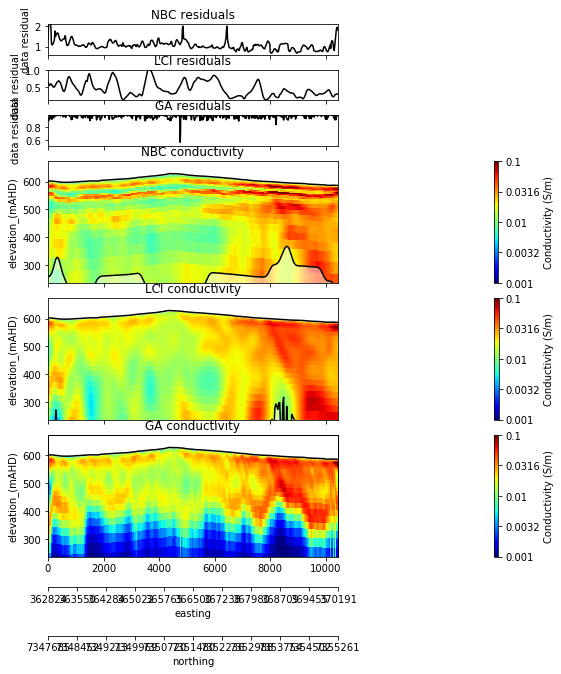

In [111]:
# Panel plotting different CGI inversions

vex = 10.

max_depth = 350.

vmin, vmax = 0.001,0.1

# NOte that the vertical exaggeration and the max depth don't always play nicely
panel_settings = {'panel_1': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'NBC residuals', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  'panel_2': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'LCI residuals', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  'panel_3': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'GA residuals', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  'panel_4': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'NBC conductivity',
                                              'max_depth': max_depth, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': vmin, 'vmax': vmax,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':vex},
                             'height_ratio': 4},
                  
                 'panel_5': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'LCI conductivity',
                                              'max_depth': max_depth, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': vmin, 'vmax': vmax,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':vex},
                             'height_ratio': 4},
                 'panel_6': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'GA conductivity',
                                              'max_depth': max_depth, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': vmin, 'vmax': vmax,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':vex},
                             'height_ratio': 4}}

# Get ax_array length lists of the panel settings
panel_kwargs  = plot_utils.unpack_plot_settings(panel_settings,
                                             'panel_kwargs')


height_ratios = plot_utils.unpack_plot_settings(panel_settings,
                                                'height_ratio')


# Relative position of the colourbar
x0, y0, width, height = [1.01, 0., 0.02, 1.]

plot_settings = {'vertical_margin': 1.,
                    'panel_vgap': .75, 'plot_width': 11.7 #A3 width
                }                        

# Close previous plots
plt.close()

# Intialise figure
fig, ax_array = plt.subplots(len(panel_settings), 1, sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  height_ratios})

res1 = plot_utils.plot_single_line(ax_array[0], NBC_gridded_variables[line],
                                   'data_residual', panel_kwargs[0])

ax_array[0].set_title(panel_kwargs[0]['title'])

res2 = plot_utils.plot_single_line(ax_array[1], LCI_gridded_variables[line],
                                   'data_residual', panel_kwargs[1])

ax_array[1].set_title(panel_kwargs[1]['title'])

res3 = plot_utils.plot_single_line(ax_array[2], GA_gridded_variables[line],
                                   'phid', panel_kwargs[1])

ax_array[2].set_title(panel_kwargs[2]['title'])

im1 = plot_utils.plot_grid(ax_array[3], NBC_gridded_variables[line], 'conductivity',
                   panel_kwargs[3])

ax_array[3].set_title(panel_kwargs[3]['title'])


im2 = plot_utils.plot_grid(ax_array[4], LCI_gridded_variables[line], 'conductivity',
                    panel_kwargs[4])

ax_array[4].set_title(panel_kwargs[4]['title'])

im3 = plot_utils.plot_grid(ax_array[5], GA_gridded_variables[line], 'conductivity',
                    panel_kwargs[5])

ax_array[5].set_title(panel_kwargs[5]['title'])


#ax_array[5].set_xlim(0,34000)

#ax_array[3].set_xlim(20000,25000)

# Format the figure to size it for the specified vertical exaggeration
plot_utils.format_panels(ax_array, panel_settings, plot_settings)
            

# Add colorbars
plot_utils.add_colourbar(fig, ax_array[3], im1, x0, y0, width, height, panel_kwargs[3])

plot_utils.add_colourbar(fig, ax_array[4], im2, x0, y0, width, height, panel_kwargs[4])

plot_utils.add_colourbar(fig, ax_array[5], im3, x0, y0, width, height, panel_kwargs[5])


dist_max = np.min(np.array([NBC_gridded_variables[line]['grid_distances'][-1],
              LCI_gridded_variables[line]['grid_distances'][-1],
              GA_gridded_variables[line]['grid_distances'][-1]])
             )
ax_array[3].set_xlim(0,dist_max)


ax_pos = plot_utils.align_axes(ax_array)

# Add axis with northing at the bottom of the plot

north = GA_gridded_variables[line]['northing']

east = GA_gridded_variables[line]['easting']



plot_utils.add_axis_coords('northing', north, ax_array[-1], ax_pos[5], offset=-0.65)

plot_utils.add_axis_coords('easting', east, ax_array[-1], ax_pos[5], offset=-0.25)

    
outfile = os.path.join(outdir, str(line) + "_AEM_comparison_plot_log.png")

plt.savefig(outfile, dpi=300)

plt.show()

In [71]:
# Define gdal algorithm as string - see https://gdal.org/programs/gdal_grid.html
algorithm = 'invdist:power=2:radius1=250:radius2=250:max_points=10:'
algorithm += 'min_points=2:nodata=-32768.0'

grid_kwargs = {'conductivity': {'log_grid': True,
                                'gdal_algorithm': algorithm}}

start_time = time.time()

# Currently this is too resource intense, need to make it more effecient
aem_grid = spatial_functions.grid_points_gdal(cond_point_utils,
                 grid_resolution = xr,
                 variables = 'conductivity',
                 reprojected_grid_bounds = (minx, miny, maxx, maxy),
                 grid_wkt = utm_wkt,
                 point_step=4, # Only use every 4th point
                 grid_kwargs = grid_kwargs,
                 depth_inds = depth_inds)

print("Gridding time: ", time.time() - start_time, ' seconds')

'C:\\Users\\PCUser\\Desktop\\SSC_data\\AEM_data\\comparitive_sections'